# Caltech Image Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [32]:
import json

import boto3
import dill as dill

In [3]:
PATH = 'data/caltech_256/'
sz = 224
arch = resnext50
bs=32

In [4]:
def read_dirs(path, folder):
    '''
    Fetches name of all files in path in long form, and labels associated by extrapolation of directory names. 
    '''
    lbls, fnames, all_lbls = [], [], []
    full_path = os.path.join(path, folder)
    for lbl in sorted(os.listdir(full_path)):
        if lbl not in ('.ipynb_checkpoints','.DS_Store'):
            all_lbls.append(lbl)
            for fname in os.listdir(os.path.join(full_path, lbl)):
                if fname.endswith('.jpg'):
                    fnames.append(os.path.join(lbl, fname))
                    lbls.append(lbl)
    return fnames, lbls, all_lbls

In [5]:
fnames, lbls, all_lbls = read_dirs(PATH, 'train')

In [6]:
len(fnames), len(lbls), len(all_lbls)

(30607, 30607, 257)

In [7]:
label_df = pd.DataFrame({ 'id': fnames, 'label': lbls })

In [8]:
label_df.head()

,id,label
0,001.ak47/001_0034.jpg,001.ak47
1,001.ak47/001_0091.jpg,001.ak47
2,001.ak47/001_0089.jpg,001.ak47
3,001.ak47/001_0036.jpg,001.ak47
4,001.ak47/001_0014.jpg,001.ak47


In [9]:
label_df.pivot_table(index='label', aggfunc=len).sort_values('id', ascending=False)

,id
label,
257.clutter,827
251.airplanes-101,800
145.motorbikes-101,798
253.faces-easy-101,435
232.t-shirt,358
096.hammock,285
011.billiards,278
105.horse,270
126.ladder,242


In [14]:
label_df.to_csv(f'{PATH}labels.csv', index=False)

In [7]:
label_df = pd.read_csv(f'{PATH}labels.csv')

In [8]:
n = label_df.size//2
val_idxs = get_cv_idxs(n)

In [9]:
len(val_idxs)

6121

In [10]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', 
               'labels.csv', num_workers=4,
               val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [11]:
data = get_data(224, bs)

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [13]:
lrf=learn.lr_find()

 81%|████████  | 622/766 [00:09<00:02, 68.54it/s, loss=10]  


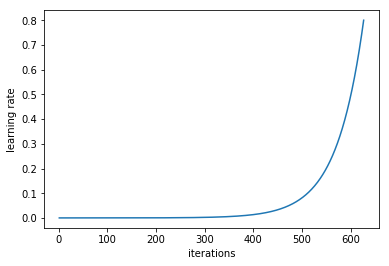

In [14]:
learn.sched.plot_lr()

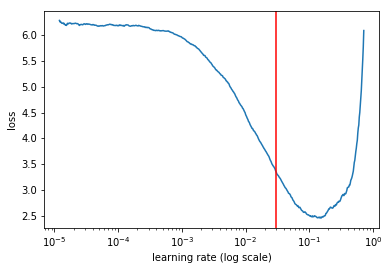

In [15]:
learn.sched.plot()
LEARN_RATE=3e-2
plt.axvline(x=LEARN_RATE, color="red");

In [16]:
learn.fit(LEARN_RATE, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                   
    0      1.169801   0.75191    0.809018  



In [17]:
learn.precompute=False
learn.fit(LEARN_RATE, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.928369   0.630769   0.840549  
    1      0.893449   0.610089   0.843816                    
    2      0.83536    0.597778   0.846594                    



[array([0.59778]), 0.8465936938603511]

In [18]:
learn.unfreeze()
lr=np.array([3e-4,3e-3,3e-2])

In [19]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.909587   0.570148   0.852148  
    1      0.831682   0.596083   0.848064                    
    2      0.364561   0.498567   0.872406                    
    3      0.686825   0.716752   0.829276                    
    4      0.390701   0.564518   0.864565                    
    5      0.181272   0.50661    0.882862                    
    6      0.123983   0.49211    0.882372                    



[array([0.49211]), 0.8823721614407473]

In [21]:
torch.save(learn.model, f'{PATH}models/caltech_256_resnext50_224.pt', pickle_module=dill)

In [55]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

In [22]:
learn.set_data(get_data(299, bs))

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.135824   0.472587   0.883352  
    1      0.151426   0.502781   0.878615                    
    2      0.113729   0.494162   0.879268                     
    3      0.122094   0.519704   0.880902                    
    4      0.105897   0.514901   0.882536                     
    5      0.112313   0.510579   0.884169                     
    6      0.080671   0.511341   0.885476                     



[array([0.51134]), 0.8854762294034985]

In [24]:
torch.save(learn.model, f'{PATH}models/caltech_256_resnext50_299.pt', pickle_module=dill)

In [58]:
learn.save('299')

In [ ]:
learn.load('299')

In [25]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.8907041333115504

# Analyse results

In [61]:
preds = np.argmax(probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 13   0   0 ...   0   0   0]
 [  0  14   0 ...   0   0   1]
 [  0   0  28 ...   0   0   0]
 ...
 [  0   0   0 ...  15   0   0]
 [  0   0   0 ...   0  20   0]
 [  0   0   0 ...   0   0 141]]


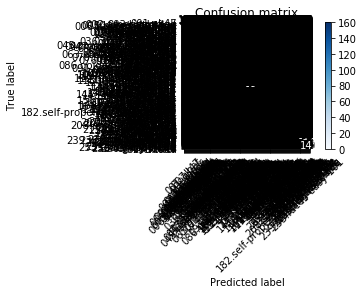

In [62]:
plot_confusion_matrix(cm, data.classes)

## Save classes json file

In [28]:
with open(f'{PATH}/models/classes.json', 'w') as outfile:
    json.dump(json.dumps(all_lbls), outfile)

## Create tarball with model file

In [29]:
!tar czvf data/caltech_256/model.tar.gz -C data/caltech_256/models/ caltech_256_resnext50_299.pt classes.json

caltech_256_resnext50_299.pt
classes.json


## Upload model to S3

In [30]:
bucket='sagemaker-mcclean-eu-west-1'          # customize to the name of your S3 bucket
key='models/caltech256_fastai/model.tar.gz'   # prefix of the S3 bucket of the model file

In [33]:
boto3.client('s3').upload_file(PATH+"model.tar.gz", bucket, key)
print(f"Uploaded model artefacts to s3://{bucket}/{key}")

Uploaded model artefacts to s3://sagemaker-mcclean-eu-west-1/models/caltech256_fastai/model.tar.gz
